# Үй тапсырмасы: Банк клиенттерінің кетуін болжау (Customer Churn Prediction)

**Тақырыбы:** Нейрондық желілер негіздері (Classification).

**Мақсаты:**

1. Шынайы деректер жинағын (Dataset) өңдеу және талдау.
2. Категориялық деректерді цифрлық форматқа ауыстыру.
3. Терең оқыту (Deep Learning) моделін, яғни көпқабатты персептронды құру.
4. Модельдің дәлдігін бағалау.

**Деректер жинағы:**
Біз 10,000 банк клиенті туралы ақпаратты қолданамыз. Мақсат — клиенттің банк қызметінен бас тарту-тартпауын (`Exited` бағаны: 1 немесе 0) болжау.



## 1. Қысқаша теория

Бұл есеп — **бинарлы классификация** (екі класқа бөлу) мәселесі.

**Нейрондық желі архитектурасы:**

1. **Кіріс қабаты (Input Layer):** Клиенттің белгілеріне (жасы, жалақысы, елі, т.б.) сәйкес келетін нейрондар саны.
2. **Жасырын қабаттар (Hidden Layers):** Деректердегі күрделі заңдылықтарды анықтайды. Белсендіру функциясы ретінде әдетте **ReLU** () қолданылады.
3. **Шығыс қабаты (Output Layer):** Бинарлы классификация үшін 1 нейрон қолданылады. Белсендіру функциясы — **Sigmoid** (), себебі ол бізге 0 мен 1 арасындағы ықтималдықты береді.

In [1]:
# Қажетті кітапханаларды импорттау
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Кездейсоқ сандар генераторын бекіту (нәтиже тұрақты болу үшін)
tf.random.set_seed(42)
np.random.seed(42)

print("Кітапханалар сәтті жүктелді!")

Кітапханалар сәтті жүктелді!




## 2. Деректерді жүктеу және шолу

Біз деректерді GitHub репозиторийінен тікелей жүктейміз.


In [5]:
# Деректерді оқу
url = "https://github.com/sharmaroshan/Churn-Modelling-Dataset/blob/master/Churn_Modelling.csv"

# Алғашқы 5 жолды шығару
df = pd.read_csv('../data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Деректердің жалпы сипаттамасы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB



## 3. Деректерді алдын ала өңдеу (Preprocessing)

Бұл кезеңде біз модельге қажетсіз бағандарды өшіріп, мәтіндік деректерді сандарға айналдырамыз.

**Тапсырма 1:** Төмендегі бағандар модельге пайдасыз, себебі олар клиенттің кетуіне әсер етпейді:

* `RowNumber`
* `CustomerId`
* `Surname`

Осы бағандарды өшіріңіз.


In [10]:

# TODO: "RowNumber", "CustomerId", "Surname" бағандарын өшіріңіз (drop функциясын қолданыңыз)

df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Тексеру
print(df.shape)
df.head(3)

(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1




### Категориялық айнымалыларды кодтау

Бізде екі мәтіндік баған бар: `Geography` (Ел) және `Gender` (Жыныс). Нейрондық желі тек сандармен жұмыс істейді.

* `Gender` -> Label Encoding (Erkak=1, Ayel=0).
* `Geography` -> One-Hot Encoding (France, Germany, Spain бағандарына бөлу).

**Тапсырма 2:** `Gender` бағанын сандық форматқа, ал `Geography` бағанын One-Hot форматына ауыстырыңыз.


In [11]:
# Gender бағанын кодтау (Label Encoding)
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

# TODO: Geography бағаны үшін One-Hot Encoding жасаңыз (pd.get_dummies қолданыңыз)
# drop_first=True параметрін қолдану ұсынылады (мультиколлинеарлықты болдырмау үшін)

df = pd.get_dummies(df, columns=['Geography'], drop_first=True) 
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True



## 4. Деректерді бөлу және масштабтау (Scaling)

Нейрондық желілер үшін деректердің масштабталуы өте маңызды. Мысалы, `EstimatedSalary` (мыңдаған) және `Age` (ондаған) әртүрлі диапазонда. Біз оларды бірдей диапазонға келтіруіміз керек.


In [12]:
# Белгілер (X) мен нысаналы айнымалыны (y) бөлу
X = df.drop('Exited', axis=1)
y = df['Exited']

# TODO: Деректерді оқу (train) және тест (test) жиындарына бөліңіз (20% тест үшін)
# random_state=42 параметрін қолданыңыз
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабтау (StandardScaler)
scaler = StandardScaler()

# TODO: scaler-ді X_train деректеріне үйретіп (fit), X_train мен X_test-ті түрлендіріңіз (transform)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (8000, 11)
X_test shape: (2000, 11)




## 5. Нейрондық желіні құру

Біз `Sequential` моделін қолданамыз.

**Тапсырма 3:** Төмендегі архитектураны құрыңыз:

1. **Кіріс қабаты + 1-ші жасырын қабат:** Нейрондар саны (мысалы, 16 немесе 32), белсендіру функциясы 'relu'. `input_dim` параметрін дұрыс көрсетіңіз.
2. **2-ші жасырын қабат:** Нейрондар саны (мысалы, 8 немесе 16), белсендіру функциясы 'relu'.
3. **Шығыс қабаты:** 1 нейрон, белсендіру функциясы 'sigmoid' (бинарлы классификация үшін).



In [ ]:
model = Sequential()

# TODO: Қабаттарды қосыңыз (add әдісі арқылы)

# 1-қабат
model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1])) 

# 2-қабат (Жасырын)
model.add(Dense(units=16, activation='relu')) 

# 3-қабат (Шығыс)
model.add(Dense(units=1, activation='sigmoid'))

# Модель құрылымын қарау
model.summary()

c:\Users\jekim\OneDrive\Desktop\Notes-on-ML-Courses\tf_venv\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)



## 6. Модельді компиляциялау және оқыту

* **Optimizer:** `adam` (ең кең таралған оптимизатор).
* **Loss Function:** `binary_crossentropy` (бинарлы классификация үшін стандарт).
* **Metrics:** `accuracy`.


In [14]:
# Компиляция
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# TODO: Модельді оқыту (fit)
# batch_size=32, epochs=50 (немесе 100) қолданыңыз
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50, # Осы жерді толтырыңыз
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7987 - loss: 0.4741 - val_accuracy: 0.8170 - val_loss: 0.4190
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8205 - loss: 0.4151 - val_accuracy: 0.8270 - val_loss: 0.3937
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8399 - loss: 0.3851 - val_accuracy: 0.8430 - val_loss: 0.3670
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8525 - loss: 0.3613 - val_accuracy: 0.8555 - val_loss: 0.3531
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8572 - loss: 0.3492 - val_accuracy: 0.8585 - val_loss: 0.3475
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3427 - val_accuracy: 0.8610 - val_loss: 0.3444
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8609 - loss: 0.3385 - val_accuracy: 0.8595 - val_loss: 0.3425
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8620 - loss: 0.3358 - val_accuracy: 0.



## 7. Нәтижелерді бағалау

Оқыту барысындағы дәлдік (accuracy) және шығын (loss) графиктерін салайық.


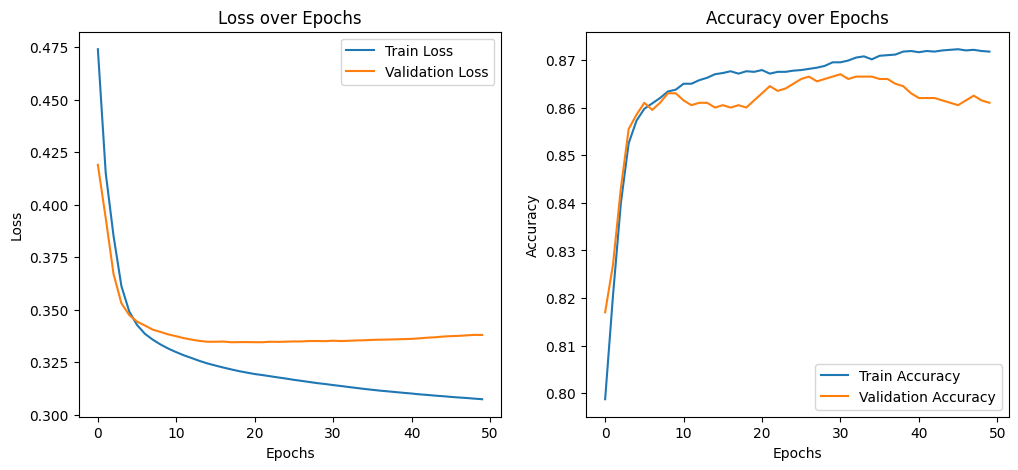

In [15]:
# Графиктерді салу
plt.figure(figsize=(12, 5))

# Loss графигі
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy графигі
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



## 8. Болжам жасау және Метрикалар

Модель 0 мен 1 арасындағы ықтималдықты қайтарады. Біз оны 0.5 шегін (threshold) қолданып, нақты класқа (0 немесе 1) айналдыруымыз керек.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Болжам жасау
y_pred_prob = model.predict(X_test)

# TODO: Ықтималдықты 0 немесе 1 класына айналдырыңыз (егер > 0.5 болса 1, әйтпесе 0)
y_pred = (y_pred_prob > 0.5).astype(int)

# Нәтижелер
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[1533   74]
 [ 204  189]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1607
           1       0.72      0.48      0.58       393

    accuracy                           0.86      2000
   macro avg       0.80      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000




## Қорытынды сұрақтар

Төмендегі сұрақтарға жауап жазыңыз (мәтін түрінде):

1. Модельдің тест деректеріндегі дәлдігі (accuracy) қандай болды?
2. Precision және Recall мәндерінің айырмашылығы неде және бұл есеп үшін қайсысы маңыздырақ деп ойлайсыз? (Банк үшін клиенттің кететінін алдын ала білу маңызды).
3. Егер `epochs` санын тым көп арттырсақ (мысалы, 100-ге), не болуы мүмкін? (Overfitting туралы ойланыңыз).